In [3]:
!pip install kaggle

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d aswathrao/demand-forecasting

# Assuming the downloaded file is a zip archive:
!unzip demand-forecasting.zip -d /content/dataset

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/aswathrao/demand-forecasting
License(s): unknown
demand-forecasting.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  demand-forecasting.zip
  inflating: /content/dataset/sample_submission_pzljTaX.csv  
  inflating: /content/dataset/test_nfaJ3J5.csv  
  inflating: /content/dataset/train_0irEZ2H.csv  


##IMPORTS

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import GridSearchCV

##LOAD DATA

In [5]:
df = pd.read_csv('/content/dataset/train_0irEZ2H.csv')

In [6]:
df.head()

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold
0,1,17/01/11,8091,216418,99.0375,111.8625,0,0,20
1,2,17/01/11,8091,216419,99.0375,99.0375,0,0,28
2,3,17/01/11,8091,216425,133.9500,133.9500,0,0,19
3,4,17/01/11,8091,216233,133.9500,133.9500,0,0,44
4,5,17/01/11,8091,217390,141.0750,141.0750,0,0,52


In [7]:
df[['day','month','year']] = df['week'].str.split('/', expand = True)
df.drop('week', axis = 1, inplace = True)
df.head()

,record_ID,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold,day,month,year
0,1,8091,216418,99.0375,111.8625,0,0,20,17,01,11
1,2,8091,216419,99.0375,99.0375,0,0,28,17,01,11
2,3,8091,216425,133.9500,133.9500,0,0,19,17,01,11
3,4,8091,216233,133.9500,133.9500,0,0,44,17,01,11
4,5,8091,217390,141.0750,141.0750,0,0,52,17,01,11


##TRAINING MODEL

In [13]:
X,y = df.drop('units_sold', axis=1), df['units_sold']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [14]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [16]:
model.score(X_test, y_test)

0.7789579088228198

In [19]:
# RMS
y_pred = model.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)
print("Root Mean Squared Error:", rmse)

Root Mean Squared Error: 26.930781424827764


##PRE-PROCESSING

In [22]:
df.units_sold.describe()

,units_sold
count,150150.000000
mean,51.674206
std,60.207904
min,1.000000
25%,20.000000
50%,35.000000
75%,62.000000
max,2876.000000


<Axes: >

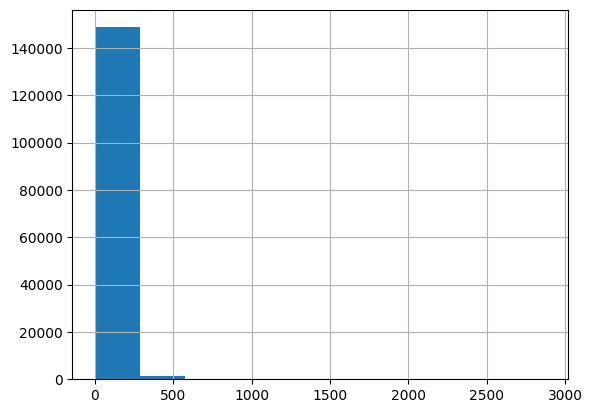

In [23]:
df.units_sold.hist()

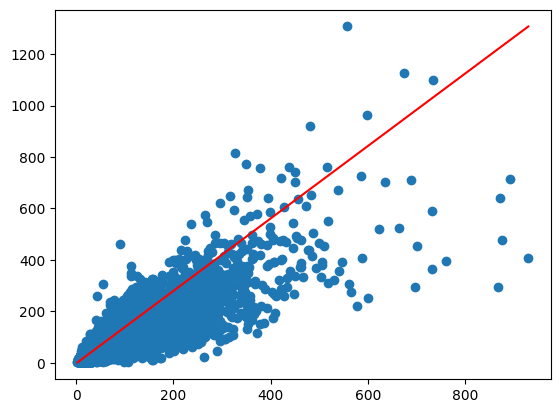

In [26]:
plt.scatter(y_pred, y_test)
plt.plot(np.linspace(y_pred.min(), y_pred.max()), np.linspace(y_test.min(), y_test.max()), color='r')

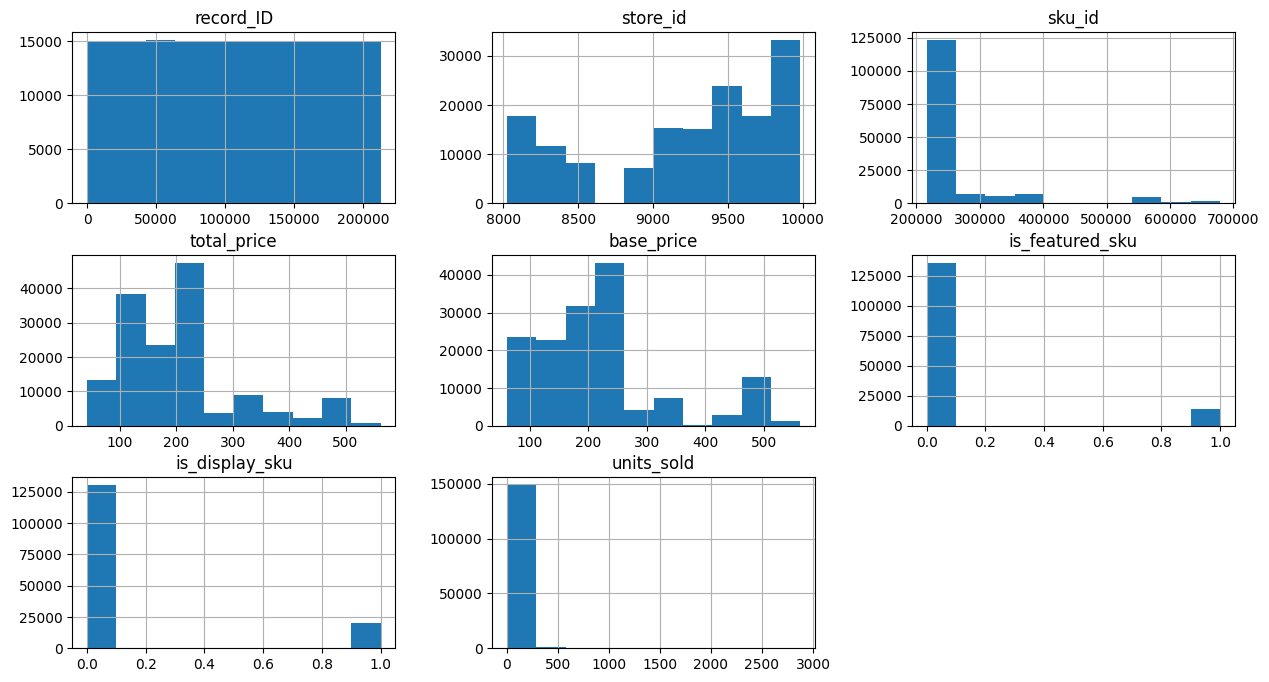

In [27]:
df.hist(figsize=(15,8))
plt.show()

In [28]:
df.drop('record_ID', axis=1, inplace=True)

In [29]:
len(df.store_id.unique())

76

In [30]:
len(df.sku_id.unique())

28

<Axes: >

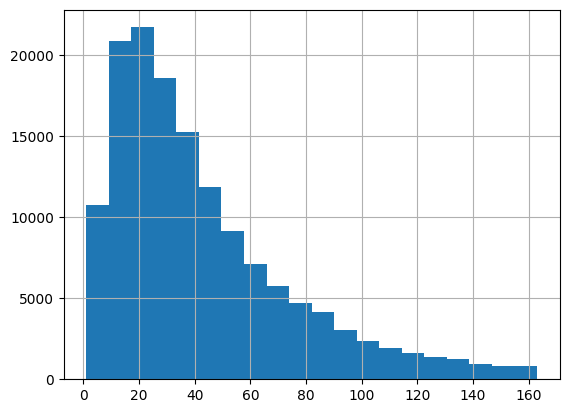

In [34]:
df = df[df.units_sold < df.units_sold.quantile(0.99)]
df.units_sold.hist(bins=20)

In [36]:
df = df.join(pd.get_dummies(df.store_id, prefix='store')).drop('store_id', axis=1)
df = df.join(pd.get_dummies(df.sku_id, prefix='item')).drop('sku_id', axis=1)


##TRAIN MODEL ON PRE-PROCESSED DATASET



In [38]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
X, y = df.drop('units_sold',axis=1),df['units_sold']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [39]:
model.score(X_test, y_test)

0.7945057991316723

In [41]:
y_pred = model.predict(X_test)
rmse = root_mean_squared_error(y_pred, y_test)
print("Root Mean Squared Error:", rmse)

Root Mean Squared Error: 14.777485652459719


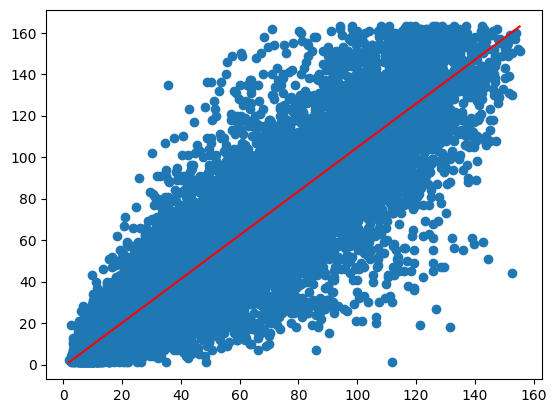

In [42]:
plt.scatter(y_pred, y_test)
plt.plot(np.linspace(y_pred.min(), y_pred.max()), np.linspace(y_test.min(), y_test.max()), color='r')

##HYPER_PARAMETER TUNING

In [53]:
param_grid = {
    'n_estimators': [10, 20],
    'min_samples_split': [2, 3]
}
model = RandomForestRegressor(n_jobs = -1)
grid_search = GridSearchCV(model, param_grid=param_grid, verbose=2, cv=5)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END ...............min_samples_split=2, n_estimators=10; total time=  14.6s
[CV] END ...............min_samples_split=2, n_estimators=10; total time=  14.1s
[CV] END ...............min_samples_split=2, n_estimators=10; total time=  14.2s
[CV] END ...............min_samples_split=2, n_estimators=10; total time=  14.5s
[CV] END ...............min_samples_split=2, n_estimators=10; total time=  15.1s
[CV] END ...............min_samples_split=2, n_estimators=20; total time=  32.3s
[CV] END ...............min_samples_split=2, n_estimators=20; total time=  34.5s
[CV] END ...............min_samples_split=2, n_estimators=20; total time=  28.2s
[CV] END ...............min_samples_split=2, n_estimators=20; total time=  28.1s
[CV] END ...............min_samples_split=2, n_estimators=20; total time=  28.4s
[CV] END ...............min_samples_split=3, n_estimators=10; total time=  14.0s
[CV] END ...............min_samples_split=3, n_es

GridSearchCV(cv=5, estimator=RandomForestRegressor(n_jobs=-1),
             param_grid={'min_samples_split': [2, 3], 'n_estimators': [10, 20]},
             verbose=2)

In [54]:
best_model = grid_search.best_estimator_
grid_search.best_params_

{'min_samples_split': 2, 'n_estimators': 20}

In [55]:
best_model.score(X_test, y_test)

0.7872579232679757